# Extraction, lecture et vérification des données

## Extraction et lecture

On commence par récupérer les jeux de données et on les sauvegarde en local pour une utilisation ultérieure.

In [1]:
import urllib
import os, gzip
data_url = ["http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz",
            "http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz"]
filenames = []
raw_data = {}
for url in data_url:
    fname = url.split('/')[-1]  ## get file name from url, which is everything after the last '/'
    filenames.append(fname)
    if os.path.isfile(fname):
        print("Reading local version of", fname)
    else:
        print("Downloading remote version for", url)
        urllib.request.urlretrieve(url, fname)  ## this downloads url and save file to fname
        
    with gzip.open(fname, 'rt') as file:
        raw_data[fname] = file.readlines()
        print(raw_data[fname][0])  ## print first line to check it worked

Reading local version of liglab2.log.gz
[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms

Reading local version of stackoverflow.log.gz
[1421771203.082701] 1257 bytes from stackoverflow.com (198.252.206.140): icmp_seq=1 ttl=50 time=120 ms



## Vérification des données

Les données sont des fichiers textes où chaque ligne est de la forme:

\[**timestamp**\] **size** bytes from **url** (**ip**): icmp_seq=**icmp_seq** ttl=**ttl** time=**time**

- **timestamp** est l'instant d'émission de la requête (flottant);
- **size** est la taille de la requête en octets (entier);
- **url** est l'url vers laquelle la requête a été envoyée (chaîne de caractères);
- **ip** est l'adresse ip de l'url précédente (chaîne de caractères);
- **icmp_seq** et **ttl** sont ignorées;
- **time** est le temps aller-retour entre l'ordinateur d'envoi et l'url spécifiée (flottant + chaîne de caractères).

Pour vérifier les données, nous utilisons des expressions régulières. Les données vérifiées sont ensuites insérées dans un DataFrame de pandas pour traitement.

In [2]:
import re
import pandas as pd

pingoutput = re.compile(r'\[(?P<timestamp>\d*\.\d*)\]'  ## match timestamp as floating number
                        r' (?P<size>\d*) bytes from '   ## match size as integer
                        r'(?P<url>(\w[\w\-]*\.)*\w*) '  ## match simple urls
                        r'\((?P<ip>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\)' ## match ips
                        r': icmp_seq=(?P<icmp_seq>\d*) '## match icmp_seq
                        r'ttl=(?P<ttl>\d*) '            ## match ttl
                        r'time=(?P<ping>\d*\.?\d*) ms'  ## match time with unit
                        , flags=re.ASCII|re.IGNORECASE)
data = {}
for fname in filenames:
    data[fname] = pd.DataFrame(columns=['timestamp', 'size', 'url', 'ip',
                             'icmp_seq', 'ttl', 'ping'])
    rdata = []
    errors = 0
    for i, line in enumerate(raw_data[fname]):
        m = pingoutput.match(line)
        if m is None:
            errors = errors + 1
            continue
        rdata.append({'timestamp':pd.Timestamp(float(m.group('timestamp')), unit='s'),
                     'size':int(m.group('size')), 'url':m.group('url'),
                     'ip':m.group('ip'),'icmp_seq':int(m.group('icmp_seq')),
                     'ttl':int(m.group('ttl')), 'ping':float(m.group('ping'))})
    data[fname] = pd.DataFrame(rdata)
    print('{:d} lines failed parsing in {:s}'.format(errors, fname))

377 lines failed parsing in liglab2.log.gz
63 lines failed parsing in stackoverflow.log.gz


Nous pouvons désormais observer l'évolution du ping en fonction du temps, ici dans le cas du premier fichier.

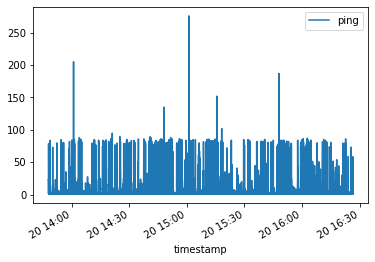

In [3]:
%matplotlib inline
df = data[filenames[0]]
df.plot(x="timestamp", y="ping")

On constate de très fortes variation avec des pics dépassant les 150, bien loin de la moyenne qui semble être 80.

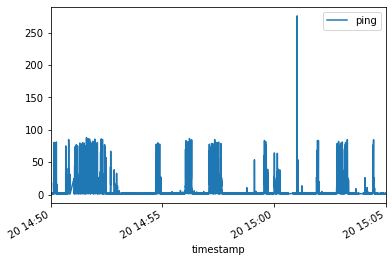

In [4]:
df.plot(x="timestamp", y="ping",
            xlim=(pd.Timestamp('2015-01-20 14:50:00'),
                  pd.Timestamp('2015-01-20 15:05:00')))

On constate en zoomant que la majeure partie du temps, le ping est proche de 0, monte parfois à 90 et présente des pics au delà de 150. Ces variations ne peuvent être expliquées par les variations de taille de paquet.

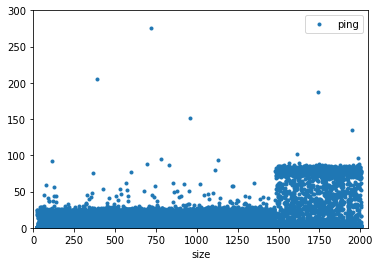

In [14]:
df.plot(x="size", y="ping", style='.', xlim=(0,2048), ylim=(0,300))

La taille du paquet n'est pas corrélée avec le ping. Cependant, on observe une marche pour une taille supérieure à 1500, ce qui indique une granularité du fonctionnement des requêtes de ping. On estime finement la position de cette marche en zoomant la figure.

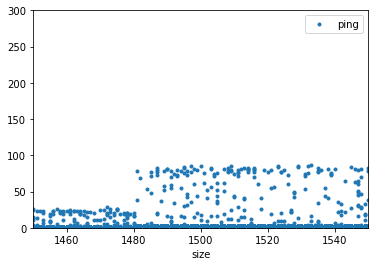

In [18]:
df.plot(x="size", y="ping", style='.', xlim=(1450,1550), ylim=(0,300))

La rupture se passe pour une taille de 1480 octets.

ModuleNotFoundError: No module named 'scipy'